# Multi abstract classifier

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import urllib
import feedparser
import random
import os
import time
import pandas as pd

## Functions

In [2]:
def search_abstracts(search_query, start, max_results):
    ''' Access the Arxiv API and return a collection of papers.
        
        Arguments:
        
        search_query -- paper topic
        start -- the starting point of papers to be selected
        max_results -- max number of papers to be returned
        
        --------        
        return:
        
        feed -- a collection of papers with a variety of information
        
    '''
    # calling the api: http://export.arxiv.org/api/{method_name}?{parameters}
    base_url = 'https://export.arxiv.org/api/query?';

    query = 'search_query=%s&start=%i&max_results=%i' % (search_query,
                                                     start,
                                                     max_results)

    feedparser._FeedParserMixin.namespaces['http://a9.com/-/spec/opensearch/1.1/'] = 'opensearch'
    feedparser._FeedParserMixin.namespaces['http://arxiv.org/schemas/atom'] = 'arxiv'

    # perform a GET request using the base_url and query
    response = urllib.request.urlopen(base_url+query).read()
    feed = feedparser.parse(response)
    return feed

In [49]:
def create_files():
    ''' Create a folder on the current working directory containing a list of abstracts from multiple classes'''
    
    # Search for a set of new abstracts (not used for training or testing)
    physics_feed = search_abstracts('all:physics', start = 3000, max_results = 100)
    math_feed = search_abstracts('all:math', start = 3000, max_results = 100)
    chem_feed = search_abstracts('all:chemistry', start = 3000, max_results = 100)
    hist_feed = search_abstracts('all:history', start = 3000, max_results= 100)
    bio_feed = search_abstracts('all:biology', start = 3000, max_results= 100)

    physics_abstracts = [entry.summary for entry in physics_feed.entries]
    math_abstracts = [entry.summary for entry in math_feed.entries]
    chem_abstracts = [entry.summary for entry in chem_feed.entries]
    hist_abstracts = [entry.summary for entry in hist_feed.entries]
    bio_abstracts = [entry.summary for entry in bio_feed.entries]

    all_abst = physics_abstracts + math_abstracts + chem_abstracts + hist_abstracts + bio_abstracts

    random.shuffle(all_abst)

    # get current directory and create new folder
    current_dir = os.getcwd()
    new_folder_path = current_dir+os.sep+'Multi_abstracts_files'
    try:
        os.mkdir(new_folder_path)
    except FileExistsError:
        pass
    
    # Save all the abstracts to this new directory
    for abstr in range(len(all_abst)):
        name = 'file'+'_'+str(abstr)+'.txt'
        with open(new_folder_path+os.sep+name, 'w') as f:
            f.write(all_abst[abstr])
    return new_folder_path

In [4]:
def classify_abstract(path_to_files, classifier, Tfidf):
    ''' Use the trained classifier to correctly label the downloaded abstracts after using create_files(). 
        Create folders containing each type of abstract.
        
        Argumenst:
        
        path_to_files -- path to the created files after using create_files()
        classifier -- trained classisfier
        Tfidf -- TfidfVectorizer() object
        
    '''
    
    for file in os.listdir(path_to_files):
        with open(path_to_files+os.sep+file, 'r') as f:
            
            trans = Tfidf.transform([f.read()]).toarray()
            
            abstr_class = classifier.predict(trans)
      
            if abstr_class == 0:
                abstr_class = 'physics'
            if abstr_class == 1:
                abstr_class = 'math'
            if abstr_class == 2:
                abstr_class = 'chemistry'
            if abstr_class == 3:
                abstr_class = 'history'
            if abstr_class == 4:
                abstr_class = 'biology'
                
            abstr_class_path = path_to_files+os.sep+abstr_class+'_abstracts'
            
            try:
                os.mkdir(abstr_class_path)
            except FileExistsError:
                pass
        os.rename(f.name, abstr_class_path+os.sep+abstr_class+'_'+file)

## Create dataset

In [5]:
st = time.time()
# Search for physics, math, chemistry papers
physics_feed = search_abstracts('all:physics', start = 0, max_results = 5000)
math_feed = search_abstracts('all:math', start = 0, max_results = 5000)
chem_feed = search_abstracts('all:chemistry', start = 0, max_results= 5000)
hist_feed = search_abstracts('all:history', start = 0, max_results= 5000)
bio_feed = search_abstracts('all:biology', start = 0, max_results= 5000)
end = time.time()
print('time spent:',end-st)

time spent: 511.2986660003662


In [6]:
# Create dictionaries for each topic
physics_abstracts = { 'Types': ['Physics' for _ in range(len(physics_feed.entries))],
                     'Labels': [ 0 for _ in range(len(physics_feed.entries))], 
                    'Abstracts': [entry.summary for entry in physics_feed.entries]}

math_abstracts = { 'Types': ['Math' for _ in range(len(math_feed.entries))],
                    'Labels': [ 1 for _ in range(len(math_feed.entries))], 
                    'Abstracts': [entry.summary for entry in math_feed.entries]}

chem_abstracts = { 'Types': ['Chemistry' for _ in range(len(chem_feed.entries))],
                'Labels': [ 2 for _ in range(len(chem_feed.entries))], 
                    'Abstracts': [entry.summary for entry in chem_feed.entries]}

hist_abstracts = { 'Types': ['History' for _ in range(len(hist_feed.entries))],
                'Labels': [ 3 for _ in range(len(hist_feed.entries))], 
                    'Abstracts': [entry.summary for entry in hist_feed.entries]}

bio_abstracts = { 'Types': ['biology' for _ in range(len(bio_feed.entries))],
                'Labels': [ 4 for _ in range(len(bio_feed.entries))], 
                    'Abstracts': [entry.summary for entry in bio_feed.entries]}

In [7]:
# Place all topics in panda dataframe
physics_df = pd.DataFrame(physics_abstracts)
math_df = pd.DataFrame(math_abstracts)
chem_df = pd.DataFrame(chem_abstracts)
hist_df = pd.DataFrame(hist_abstracts)
bio_df = pd.DataFrame(bio_abstracts)

frames = [physics_df, math_df, chem_df, hist_df, bio_df]
all_df = pd.concat(frames)
all_df = all_df.sample(frac =1).reset_index(drop = True)

## Create features

In [8]:
# Used to obtain a Term-frequency, Inverser Document frequency matrix of features from raw documents  

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf = True, lowercase = True, min_df = 5, norm = 'l2', encoding = 'latin-1', 
                       ngram_range = (1,2), stop_words = 'english')
features = tfidf.fit_transform(all_df.Abstracts).toarray()
labels = all_df.Labels

In [9]:
# Use chi2 score to select the features with the highest values
# find terms that are most correlated to each area

from sklearn.feature_selection import chi2
import numpy as np
N = 3
for i in range(5):
    features_chi2 = chi2(features, labels == i)
    chi2_indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[chi2_indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("Area:", all_df.Types[all_df.Labels == i].values[0])
    print("Most correlated unigrams:", ', '.join(unigrams[-N:]))
    print("Most correlated bigrams:", ', '.join(bigrams[-N:]))
    print('*'*20)

Area: Physics
Most correlated unigrams: lhc, physical, physics
Most correlated bigrams: particle physics, standard model, new physics
********************
Area: Math
Most correlated unigrams: manifolds, prove, math
Most correlated bigrams: amer math, math soc, math phys
********************
Area: Chemistry
Most correlated unigrams: molecular, chemical, chemistry
Most correlated bigrams: density functional, gas phase, quantum chemistry
********************
Area: History
Most correlated unigrams: galaxies, histories, history
Most correlated bigrams: formation histories, formation history, star formation
********************
Area: biology
Most correlated unigrams: networks, biological, biology
Most correlated bigrams: gene expression, computational biology, systems biology
********************


## Test first learning algorithm

In [10]:
#Split the data into training and test data
from sklearn.model_selection import train_test_split

# Convert a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

# Transform a count matrix to a normalized tf or tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

# Test MultinamialNB algorithm
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(all_df['Abstracts'], all_df['Types'],test_size= 0.1, random_state = 0)

# Use CountVectorizer followed by TfidfTransformer
count_vect = CountVectorizer(lowercase = True, stop_words ='english', min_df = 5)
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Apply model
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [11]:
X_test.values[0]

'In this paper we prove the product formula for the c-function of\nnon-compactly causal symmetric spaces.'

In [12]:
y_test.values[0]

'Math'

In [13]:
print(clf.predict(count_vect.transform([X_test.values[0]])))

['Math']


In [14]:
X_test.values[1]

'A redesigned starting point for covariant \\phi^4_n, n\\ge 4, models is\nsuggested that takes the form of an alternative lattice action and which may\nhave the virtue of leading to a nontrivial quantum field theory in the\ncontinuum limit. The lack of conventional scattering for such theories is\nunderstood through an interchange of limits.'

In [15]:
y_test.values[1]

'Physics'

In [16]:
print(clf.predict(count_vect.transform([X_test.values[1]])))

['Physics']


## Compare multiple algorithms

In [17]:
# Select a number of classifiers and use cross validation to select the best one
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB

classifiers = [
    BernoulliNB(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
crossVal = 5
crossVal_df = pd.DataFrame(index=range(crossVal * len(classifiers)))
values = []
for classifier in classifiers:
    classifier_name = classifier.__class__.__name__
    accuracies = cross_val_score(classifier, features, labels, scoring='accuracy', cv=crossVal)
    for fold_indx, accuracy in enumerate(accuracies):
        values.append((classifier_name, fold_indx, accuracy))

crossVal_df = pd.DataFrame(values, columns=['classifier_name', 'fold_indx', 'accuracy'])


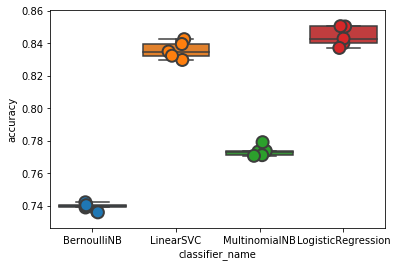

In [18]:
# Plot the classifiers accuracy
import seaborn as sns

sns.boxplot(x='classifier_name', y='accuracy', data=crossVal_df)
sns.stripplot(x='classifier_name', y='accuracy', data=crossVal_df, 
              size=12, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [19]:
# Selecte the best classifier
model_classif_mean = crossVal_df.groupby('classifier_name').accuracy.mean()
print(model_classif_mean)
best_classif_name = model_classif_mean[model_classif_mean == model_classif_mean.max()].index[0]
for classifier in classifiers:
    if classifier.__class__.__name__ == best_classif_name:
        selected_classifier = classifier

classifier_name
BernoulliNB           0.73928
LinearSVC             0.83568
LogisticRegression    0.84404
MultinomialNB         0.77348
Name: accuracy, dtype: float64


In [20]:
selected_classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# Train the selected classifier and plot the actual vs predicted results
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, all_df.index, test_size=0.1, random_state=0)

selected_classifier.fit(X_train, y_train)
y_pred = selected_classifier.predict(X_test)

#selected_classifier.fit(X_train_tfidf, y_train)
#y_pred = selected_classifier.predict(count_vect.transform(X_test.values))


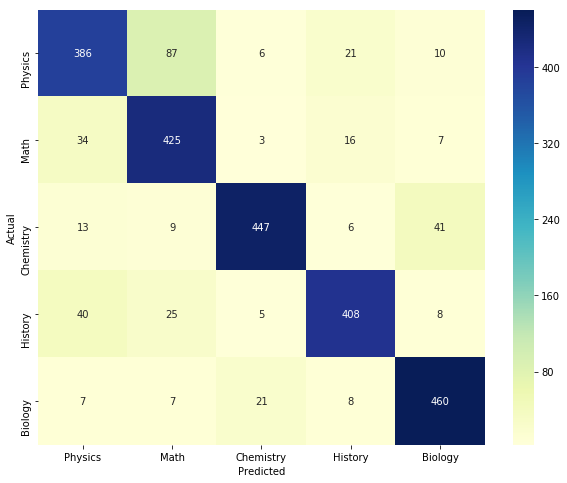

In [38]:
# Plot a confusion matrix for visualization
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred, labels = [0,1,2,3,4])

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d',
            xticklabels=['Physics', 'Math', 'Chemistry', 'History', 'Biology'], yticklabels=['Physics','Math', 'Chemistry', 'History', 'Biology'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Create and classify abstracts

In [50]:
# Download 50 abstract files per class (physics, math, chemistry, history, biology) and save them in a new folder in the current working directory. 
path = create_files()

In [51]:
ls Multi_abstracts_files # Downloaded files (50 per class)

 Volume in drive C is Windows
 Volume Serial Number is 7A3C-D3D2

 Directory of C:\Users\318310\Desktop\Data Incubator\New_notebook\Data-projects-master\Multi_abstracts_files

08/06/2018  07:47 PM    <DIR>          .
08/06/2018  07:47 PM    <DIR>          ..
08/06/2018  07:47 PM               588 file_0.txt
08/06/2018  07:47 PM               645 file_1.txt
08/06/2018  07:47 PM               652 file_10.txt
08/06/2018  07:47 PM               883 file_100.txt
08/06/2018  07:47 PM               514 file_101.txt
08/06/2018  07:47 PM               725 file_102.txt
08/06/2018  07:47 PM             1,160 file_103.txt
08/06/2018  07:47 PM               983 file_104.txt
08/06/2018  07:47 PM               817 file_105.txt
08/06/2018  07:47 PM             1,124 file_106.txt
08/06/2018  07:47 PM               284 file_107.txt
08/06/2018  07:47 PM             1,110 file_108.txt
08/06/2018  07:47 PM             1,136 file_109.txt
08/06/2018  07:47 PM               824 file_11.txt
08/06/2018  07:47 P

File Not Found


In [52]:
# Classify the downloaded abstracts
classify_abstract(path, selected_classifier, tfidf)

In [53]:
ls Multi_abstracts_files

 Volume in drive C is Windows
 Volume Serial Number is 7A3C-D3D2

 Directory of C:\Users\318310\Desktop\Data Incubator\New_notebook\Data-projects-master\Multi_abstracts_files

08/06/2018  07:47 PM    <DIR>          .
08/06/2018  07:47 PM    <DIR>          ..
08/06/2018  07:47 PM    <DIR>          biology_abstracts
08/06/2018  07:47 PM    <DIR>          chemistry_abstracts
08/06/2018  07:47 PM    <DIR>          history_abstracts
08/06/2018  07:47 PM    <DIR>          math_abstracts
08/06/2018  07:47 PM    <DIR>          physics_abstracts
               0 File(s)              0 bytes
               7 Dir(s)  306,608,218,112 bytes free


In [54]:
# Check the length of each directory (we can get an ideao of how the classification process went)
print('Classified physics abstracts:', len(os.listdir('Multi_abstracts_files/physics_abstracts/')))
print('Classified math abstracts:', len(os.listdir('Multi_abstracts_files/math_abstracts/')))
print('Classified chemistry abstracts:', len(os.listdir('Multi_abstracts_files/chemistry_abstracts/')))
print('Classified history abstracts:', len(os.listdir('Multi_abstracts_files/history_abstracts/')))
print('Classified biology abstracts:', len(os.listdir('Multi_abstracts_files/biology_abstracts/')))

Classified physics abstracts: 84
Classified math abstracts: 101
Classified chemistry abstracts: 95
Classified history abstracts: 113
Classified biology abstracts: 107
